In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import omnitool
from omnitool.literature_values import *

import sys
%pylab inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_yufull():
    sfile = '/home/oliver/PhD/Gaia_Project/data/KepxDR2/xyu18.csv'
    df = pd.read_csv(sfile,index_col=0)
    return df

def read_yurc():
    sfile = '/home/oliver/PhD/Gaia_Project/data/KepxDR2/RCxyu18.csv'
    df = pd.read_csv(sfile,index_col=0)
    return df

def read_yurc_lbcs():
    sfile = '/home/oliver/PhD/Gaia_Project/data/KepxDR2/RCxyu18_wdupes_BC.csv'
    df = pd.read_csv(sfile,index_col=0)
    return df

In [3]:
df = read_yufull()

print('Removing NaN parallaxes')
print('Before: '+str(len(df)))
df = df[np.isfinite(df.parallax)]
df = df[df.parallax_error < 0.2*df.parallax]
df.drop_duplicates('KICID',inplace=True)
df = df.reindex()
print('After: '+str(len(df)))
df.head(2)

Removing NaN parallaxes
Before: 16135
After: 15588


,KICID,numax,numax_err,dnu,dnu_err,Teff,Teff_err,yu_logg,yu_logg_err,[Fe/H],...,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist
0,757137,29.99,0.60,3.399,0.011,4751,139,2.383,0.012,-0.08,...,-0.947,DSEP,0.0,0.0,0.0,7.467,6.853,6.722,none,0.239476
1,892010,17.85,0.89,2.427,0.078,4834,151,2.161,0.023,0.21,...,-2.266,DSEP,0.0,0.0,0.0,9.784,9.168,9.041,none,0.297685


In [59]:
df = read_yurc()
df.head(2)
print(len(df))

7673


In [3]:
df = read_yurc_lbcs()
df.head(2)
print(list(df))

['kepmag_x', 'Length_Quarters', 'Length_days', 'numax', 'numax_err', 'dnu', 'dnu_err', 'amplitude', 'err.2_x', 'fwhm', 'err.3_x', 'maxbg', 'err.4_x', 'Unnamed: 14', 'Teff', 'Teff_err', 'yu_logg', 'yu_logg_err', '[Fe/H]', 'err.2_y', 'M_noCorrection', 'M_err', 'R_noCorrection', 'R_err', 'M_RGB', 'err.5', 'R_RGB', 'err.6', 'M_Clump', 'err.7', 'R_Clump', 'err.8', 'stage', 'Unnamed: 20', 'designation', 'source_id', 'gaia_ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_primary_flag', 'duplicated_source', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error'

In [6]:
'''Lets run a little test'''
df.stage[df.kmag > 12.] = 4
# df.stage[df.kmag < 9.] = 0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
'''<<<ASTEROSEISMIC>>>'''
#Now lets run scaling relations and get the bolometric magnitudes
sc = omnitool.scalings(df, df.numax, df.dnu, df. Teff,\
                      _numax_err = df.numax_err, _dnu_err = df.dnu_err,\
                      _Teff_err = df.Teff_err)
df['R'] = sc.get_radius()/Rsol
df['R_err'] = sc.get_radius_err()/Rsol
df['M'] = sc.get_mass()/Msol
df['M_err'] = sc.get_mass_err()/Msol
df['logg'] = sc.get_logg()
df['logg_err'] = sc.get_logg_err()
df['L'] = sc.get_luminosity()/Lsol
df['L_err'] = sc.get_luminosity_err()/Lsol
df['Mbol'] = sc.get_bolmag()
df['Mbol_err'] = sc.get_bolmag_err()
df['Z'] = Zsol * 10 ** df['[Fe/H]'].values

#Now lets get the bolometric correction going [LUCA VALUES]
df['ast_MKs'] = df.Mbol - df.BC_K
df['ast_MH'] = df.Mbol - df.BC_H
df['ast_MJ'] = df.Mbol - df.BC_J
df['ast_M_err'] = np.sqrt(df.Mbol_err**2 + err_bc**2)

#Now lets get the bolometric correction going [HALL VALUES]
get_bc = omnitool.bolometric_correction(df.Teff.values,\
                                       df.logg.values,\
                                       df.Z.values,)
df['aast_MKs'] = df.Mbol - get_bc(band='Ks')
df['aast_MH'] = df.Mbol - get_bc(band='H')
df['aast_MJ'] = df.Mbol - get_bc(band='J')
df['aast_M_err'] = np.sqrt(df.Mbol_err**2 + err_bc**2)

100%|██████████| 7730/7730 [00:04<00:00, 1644.37it/s]


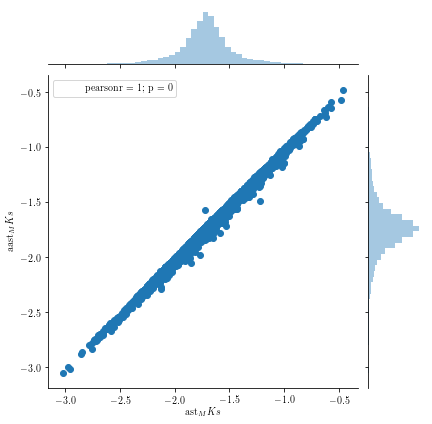

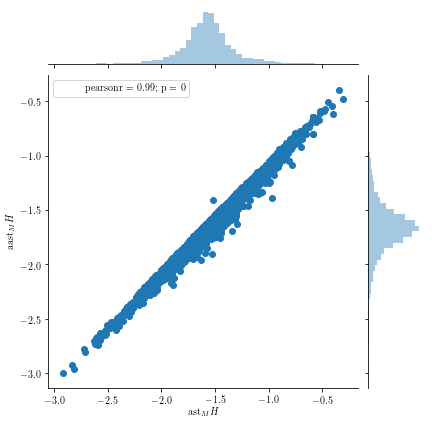

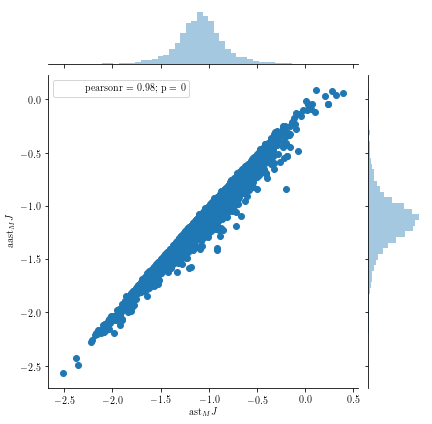

In [5]:
'''Quick test of bolocorr comparisons'''
sns.jointplot(df.ast_MKs, df.aast_MKs)
plt.show()
sns.jointplot(df.ast_MH, df.aast_MH)
plt.show()
sns.jointplot(df.ast_MJ, df.aast_MJ)
plt.show()

In [6]:
'''<<<ASTROMETRIC>>>'''
#Now lets collect the absolute magnitude from reddening
#We're going to estimate the distance uncertainties as symmetric
df['r_err'] = np.sqrt((df.r_hi-df.r_est)**2 + (df.r_est - df.r_lo)**2)

sg = omnitool.spyglass()
sg.pass_position(df.ra,df.dec,frame='icrs')
sg.pass_distance(df.r_est, df.r_err)

sg.pass_magnitude(df.kmag, band='Ks')
df['phot_MKs'], df['phot_MKs_err'] = sg.get_M()
sg.pass_magnitude(df.hmag, band='H')
df['phot_MH'], df['phot_MH_err'] = sg.get_M()
sg.pass_magnitude(df.jmag, band='J')
df['phot_MJ'], df['phot_MJ_err'] = sg.get_M()

#Now we need to check content for Nans
print('Before : '+str(len(df)))
df = df[np.isfinite(df.phot_MKs)]
df = df[np.isfinite(df.phot_MH)]
df = df[np.isfinite(df.phot_MJ)]
print('After : '+str(len(df)))

Before : 7730
After : 7725


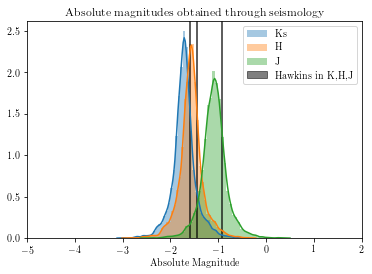

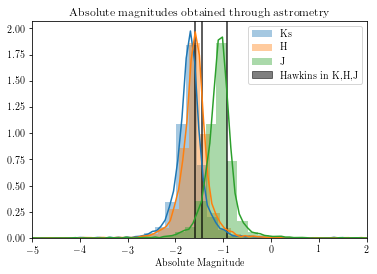

In [7]:
sns.distplot(df.ast_MKs, label='Ks')
sns.distplot(df.ast_MH,label='H')
sns.distplot(df.ast_MJ,label='J')
plt.axvspan(hawkvals['Ks']-hawkerr,hawkvals['Ks']+hawkerr,alpha=.5,color='k',label='Hawkins in K,H,J')
plt.axvspan(hawkvals['H']-hawkerr,hawkvals['H']+hawkerr,alpha=.5,color='k')
plt.axvspan(hawkvals['J']-hawkerr,hawkvals['J']+hawkerr,alpha=.5,color='k')
plt.title('Absolute magnitudes obtained through seismology')
plt.xlabel('Absolute Magnitude')
plt.legend()
plt.xlim(-5, 2.)
plt.show()

sns.distplot(df.phot_MKs, label='Ks')
sns.distplot(df.phot_MH,label='H')
sns.distplot(df.phot_MJ,label='J')
plt.axvspan(hawkvals['Ks']-hawkerr,hawkvals['Ks']+hawkerr,alpha=.5,color='k',label='Hawkins in K,H,J')
plt.axvspan(hawkvals['H']-hawkerr,hawkvals['H']+hawkerr,alpha=.5,color='k')
plt.axvspan(hawkvals['J']-hawkerr,hawkvals['J']+hawkerr,alpha=.5,color='k')
plt.title('Absolute magnitudes obtained through astrometry')
plt.xlabel('Absolute Magnitude')
plt.xlim(-5, 2.)
plt.legend()
plt.show()

/usr/local/lib/python2.7/dist-packages/seaborn/distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


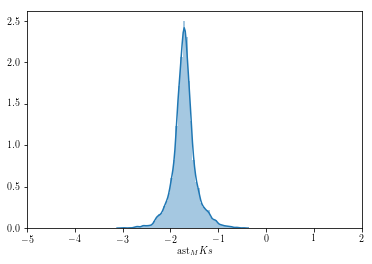

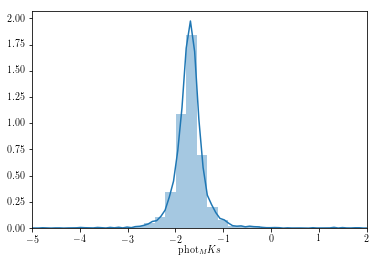

In [8]:
sel = df.stage == 2
sns.distplot(df.ast_MKs[sel], label='Ks')
sns.distplot(df.ast_MKs[~sel])
plt.xlim(-5, 2.)
plt.show()
sel = df.stage == 2
sns.distplot(df.phot_MKs[sel], label='Ks')
sns.distplot(df.phot_MKs[~sel])
plt.xlim(-5, 2.)
plt.show()


In [9]:
#Lets calculate the magnitude differences
Kdiff = df.ast_MKs - df.phot_MKs
Kdiff_err = np.sqrt(df.phot_MKs_err**2 + df.ast_M_err**2)

Hdiff = df.ast_MH - df.phot_MH
Hdiff_err = np.sqrt(df.phot_MH_err**2 + df.ast_M_err**2)

Jdiff = df.ast_MJ - df.phot_MJ
Jdiff_err = np.sqrt(df.phot_MJ_err**2 + df.ast_M_err**2)

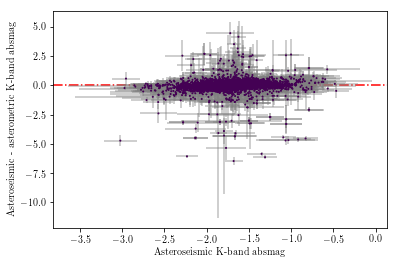

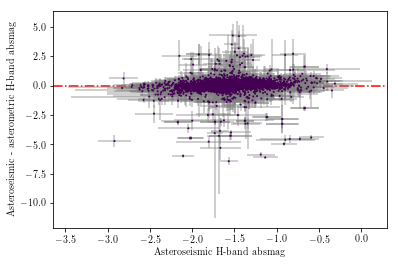

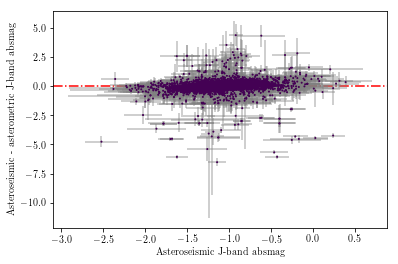

In [10]:
#Plot differences between the two magnitudes
fig, ax = plt.subplots()
diff = df.ast_MKs - df.phot_MKs
err = np.sqrt(df.phot_MKs_err**2 + df.ast_M_err**2)
ax.scatter(df.ast_MKs,diff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.ast_MKs,diff,xerr=df.ast_M_err,yerr=err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Asteroseismic K-band absmag')
ax.set_ylabel('Asteroseismic - asterometric K-band absmag')
plt.show()

fig, ax = plt.subplots()
diff = df.ast_MH - df.phot_MH
err = np.sqrt(df.phot_MH_err**2 + df.ast_M_err**2)
ax.scatter(df.ast_MH,diff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.ast_MH,diff,xerr=df.ast_M_err,yerr=err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Asteroseismic H-band absmag')
ax.set_ylabel('Asteroseismic - asterometric H-band absmag')
plt.show()

fig, ax = plt.subplots()
diff = df.ast_MJ - df.phot_MJ
err = np.sqrt(df.phot_MJ_err**2 + df.ast_M_err**2)
ax.scatter(df.ast_MJ,diff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.ast_MJ,diff,xerr=df.ast_M_err,yerr=err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Asteroseismic J-band absmag')
ax.set_ylabel('Asteroseismic - asterometric J-band absmag')
plt.show()

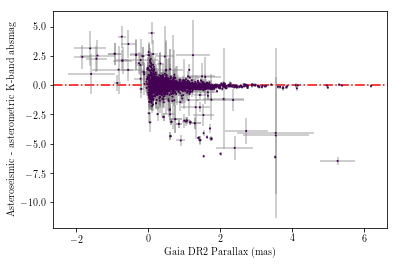

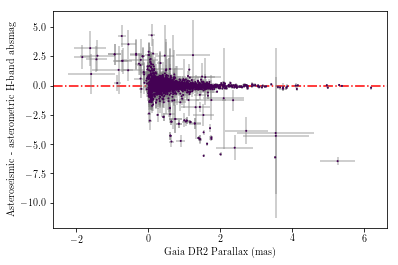

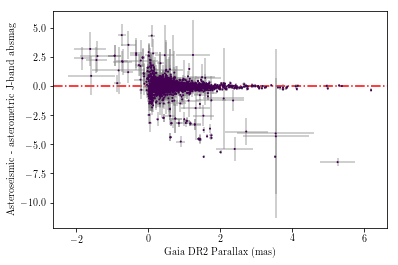

In [11]:
#Now lets plot the difference against distance
fig, ax = plt.subplots()
ax.scatter(df.parallax,Kdiff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.parallax,Kdiff,xerr=df.parallax_error,yerr=Kdiff_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Gaia DR2 Parallax (mas)')
ax.set_ylabel('Asteroseismic - asterometric K-band absmag')
plt.show()

fig, ax = plt.subplots()
ax.scatter(df.parallax,Hdiff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.parallax,Hdiff,xerr=df.parallax_error,yerr=Hdiff_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Gaia DR2 Parallax (mas)')
ax.set_ylabel('Asteroseismic - asterometric H-band absmag')
plt.show()

fig, ax = plt.subplots()
ax.scatter(df.parallax,Jdiff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.parallax,Jdiff,xerr=df.parallax_error,yerr=Jdiff_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Gaia DR2 Parallax (mas)')
ax.set_ylabel('Asteroseismic - asterometric J-band absmag')
plt.show()

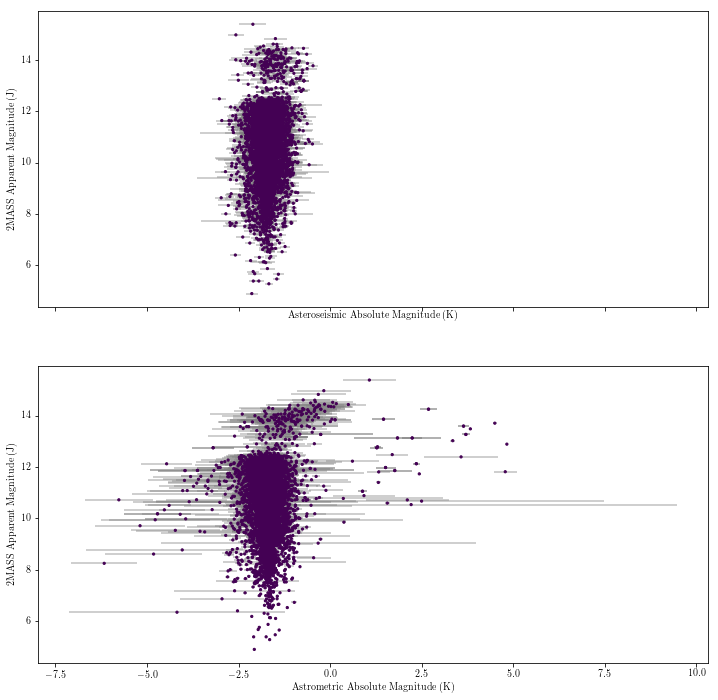

In [12]:
#Lets plot the absolute vs apparent magnitude for both types for the K band
fig, (ax1, ax2) = plt.subplots(2,sharex=True,figsize=(12,12))
ax1.scatter(df.ast_MKs,df.jmag,s=5,c=df.stage,zorder=1000)
ax1.errorbar(df.ast_MKs,df.jmag,xerr=df.ast_M_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax1.set_xlabel('Asteroseismic Absolute Magnitude (K)')
ax1.set_ylabel('2MASS Apparent Magnitude (J)')

# fig, ax = plt.subplots()
ax2.scatter(df.phot_MKs,df.jmag,s=5,c=df.stage,zorder=1000)
ax2.errorbar(df.phot_MKs,df.jmag,xerr=df.phot_MKs_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax2.set_xlabel('Astrometric Absolute Magnitude (K)')
ax2.set_ylabel('2MASS Apparent Magnitude (J)')
plt.show()

In [77]:
from astropy.table import Table
data = Table.read('../data/KepxDR2/kepler_dr2_1arcsec.fits', format='fits')
fdf = data.to_pandas()
fdf.rename(columns={'kepid':'KICID'},inplace=True)
fdf.drop_duplicates('KICID',inplace=True)

ydf = pd.read_csv('../data/KepxDR2/Mxyu18.csv')

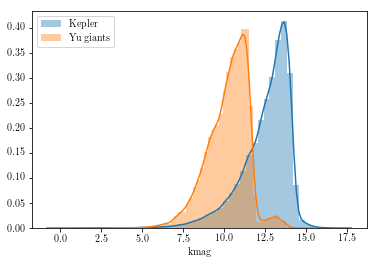

12.902
Number of seats in use : 1/5.


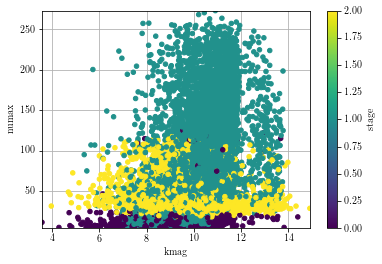

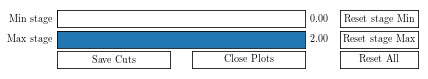

In [85]:
#Lets plot the HR diagrams for both astero for the K band
# fig, ax = plt.subplots(figsize=(10,10))
# ax.scatter(df.Teff, df.L, s=5,c=df.stage,zorder=1000)
# ax.errorbar(df.Teff, df.L, xerr=df.Teff_err, yerr=df.L_err, alpha=.5,fmt='none',c='grey',zorder=999)
# ax.set_xlabel('Teff')
# ax.set_ylabel('L')
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.gca().invert_xaxis()
# plt.show()


# sel = df.stage==4
# fig, ax = plt.subplots(figsize=(10,10))
# plt.scatter(fdf.ra, fdf.dec,s=1,alpha=.1, label='Bedell catalogue')
# plt.scatter(df.ra, df.dec,s=2,alpha=.5,label='Yu Sample')
# plt.scatter(df.ra[sel], df.dec[sel], c='r',  label='outliers')
# plt.legend()
# plt.show()
# print(len(fdf))

sel = np.isfinite(fdf.kmag)
sns.distplot(fdf.kmag[sel],label='Kepler')
sns.distplot(ydf.kmag, label='Yu giants')
plt.legend()
plt.show()
print(np.median(fdf.kmag[sel]))



# fig, ax = plt.subplots(figsize=(10,10))
# c = ax.scatter(df.Teff, df.L, s=5,c=df.M,zorder=1000)
# ax.errorbar(df.Teff, df.L, xerr=df.Teff_err, yerr=df.L_err, alpha=.5,fmt='none',c='grey',zorder=999)
# fig.colorbar(c,label='Mass')
# ax.set_xlabel('Teff')
# ax.set_ylabel('L')
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.gca().invert_xaxis()
# plt.show()

# fig, ax = plt.subplots(figsize=(8,8))
# plt.scatter(df.Teff, df.dnu, c=df.stage, s=5)
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
# plt.yscale('log')
# plt.show()

import barbershop
barber = barbershop.open(ydf, 'kmag','numax')
barber.add_client('stage')
barber.show_mirror()

In [70]:
print(list(df))
import sys
sys.exit()

['KICID', 'kepmag_x', 'Length_Quarters', 'Length_days', 'numax', 'numax_err', 'dnu', 'dnu_err', 'amplitude', 'err.2_x', 'fwhm', 'err.3_x', 'maxbg', 'err.4_x', 'Unnamed: 14', 'Teff', 'Teff_err', 'yu_logg', 'yu_logg_err', '[Fe/H]', 'err.2_y', 'M_noCorrection', 'M_err', 'R_noCorrection', 'R_err', 'M_RGB', 'err.5', 'R_RGB', 'err.6', 'M_Clump', 'err.7', 'R_Clump', 'err.8', 'stage', 'Unnamed: 20', 'designation', 'source_id', 'gaia_ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_primary_flag', 'duplicated_source', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_fl

SystemExit: 

In [ ]:
%pylab qt
import barbershop
barber=barbershop.open(df, 'ast_MKs','kmag')
barber.add_client('M')
barber.add_client('M_Clump')
barber.histograms_on(x=True)
barber.show_mirror()

In [ ]:
#Saving out the result
df.to_csv('../data/KepxDR2/Mxyu18.csv')

In [ ]:
#Saving out the result
df.to_csv('../data/KepxDR2/MRCxyu18.csv')

In [13]:
#Saving out the result
df.to_csv('../data/KepxDR2/MRCxyu18_wdupes_BC.csv')